In [174]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import pmdarima as pm
from dateutil.relativedelta import relativedelta

In [175]:
data = pd.read_excel("../datasets/dataset.xlsx",dtype={'CustomerID': str},parse_dates=['InvoiceDate'])

In [176]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# 1. Data Preprocessing 

## Making `Sale` column

In [177]:
data["Sale"] = (data['Quantity'] * data['UnitPrice']).round(2)

## Dropping Unwanted columns

In [178]:
data.drop(columns=["Description","UnitPrice","Quantity","CustomerID","InvoiceNo","Country","StockCode"], inplace=True)

## Setting index column

In [179]:
data.set_index('InvoiceDate', inplace=True)

In [180]:
data.head()

,Sale
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sale    541909 non-null  float64
dtypes: float64(1)
memory usage: 8.3 MB


## Taking Sales Summaries

In [154]:
data_daily_sales = data.resample('D').sum()

# 2. EDA

<Axes: title={'center': 'Daily Sales'}, xlabel='InvoiceDate'>

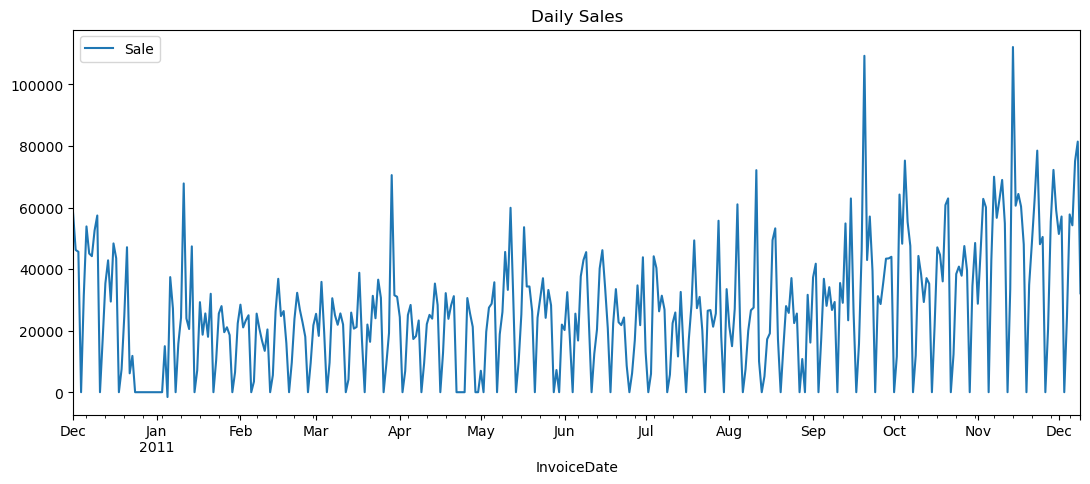

In [155]:
data_daily_sales.plot(figsize=(13, 5), title='Daily Sales')

In [156]:
def plot_decomposition(data, period, title_prefix):
    ss_decomposition = seasonal_decompose(x=data, model='additive', period=period)
    estimated_trend = ss_decomposition.trend
    estimated_seasonal = ss_decomposition.seasonal
    estimated_residual = ss_decomposition.resid

    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

    axes[0].plot(data, label='Original')
    axes[0].set_title(f'{title_prefix} Sales - Original')
    axes[0].legend(loc='upper left')

    axes[1].plot(estimated_trend, label='Trend')
    axes[1].set_title(f'{title_prefix} Sales - Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(estimated_seasonal, label='Seasonality')
    axes[2].set_title(f'{title_prefix} Sales - Seasonal')
    axes[2].legend(loc='upper left')

    axes[3].plot(estimated_residual, label='Residuals')
    axes[3].set_title(f'{title_prefix} Sales - Residuals')
    axes[3].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

def plot_acf_pacf(data, title_prefix):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(data, ax=axes[0], lags=50)
    axes[0].set_title(f'ACF - {title_prefix} Sales')

    plot_pacf(data, ax=axes[1], lags=20)
    axes[1].set_title(f'PACF - {title_prefix} Sales')

    plt.tight_layout()
    plt.show()

def plot_time_series_analysis(data_daily_sales):
    plot_decomposition(data_daily_sales, period=7, title_prefix='Daily')  

    plot_acf_pacf(data_daily_sales, title_prefix='Daily')  

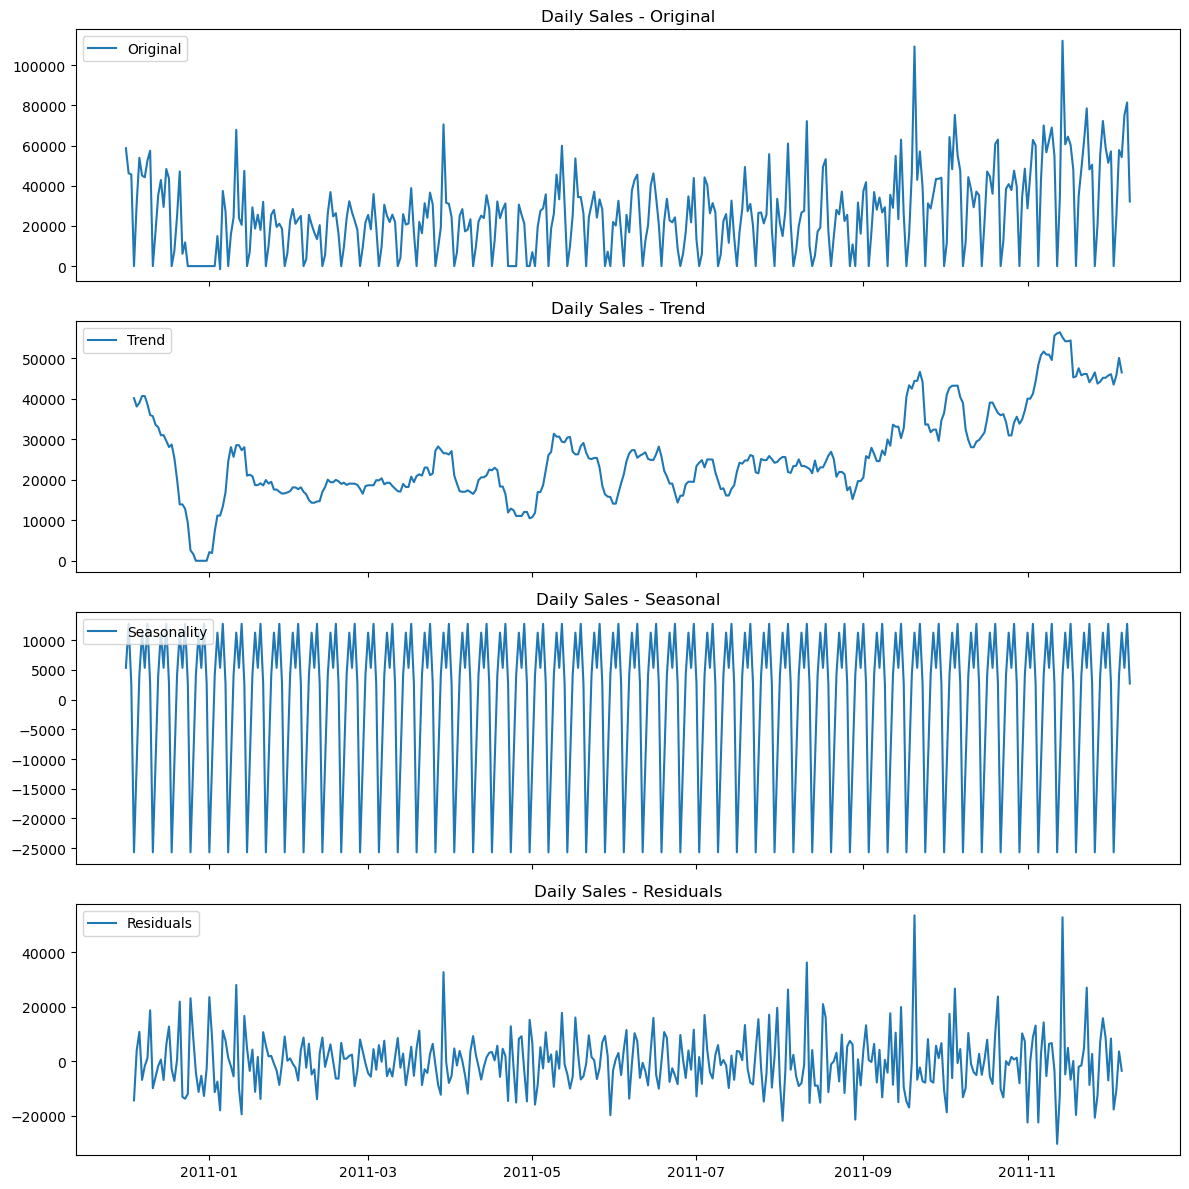

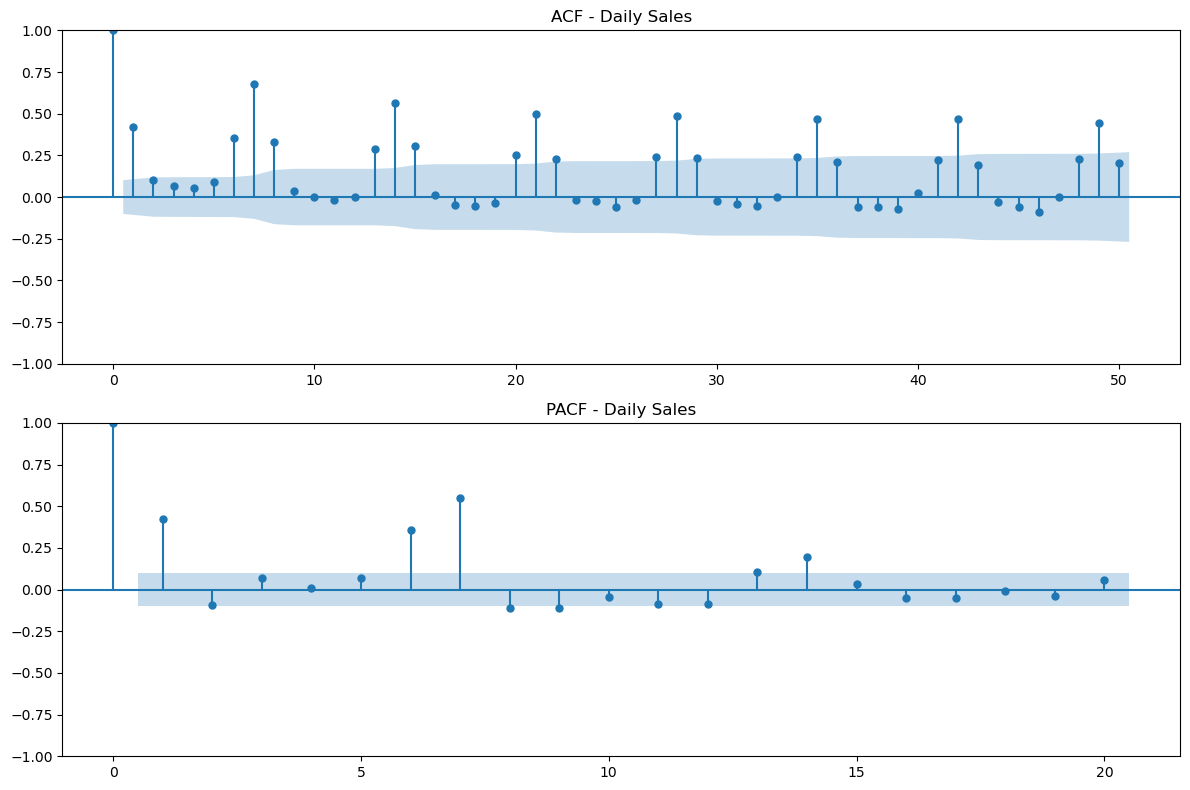

In [157]:
plot_time_series_analysis(data_daily_sales)

# 2. Forecasting 

## Using SARIMA

In [159]:
sar = sm.tsa.statespace.SARIMAX(data_daily_sales.Sale, 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,7), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Sale   No. Observations:                  374
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -3994.175
Date:                             Tue, 04 Feb 2025   AIC                           7996.351
Time:                                     14:20:07   BIC                           8011.972
Sample:                                 12-01-2010   HQIC                          8002.557
                                      - 12-09-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    119.1026    237.682      0.501      0.616    -346.745     584.951
ar.L1          0.2701      0.069      3.899      0.000       0.134       0.406
ma.S.L7       -0.7873      0.048    -16.521      0.000      -0.881      -0.694
sigma2      2.215e+08      0.002   1.42e+11      0.000    2.22e+08    2.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):               328.25
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.81e+25. Standard errors may be unstable.
"""

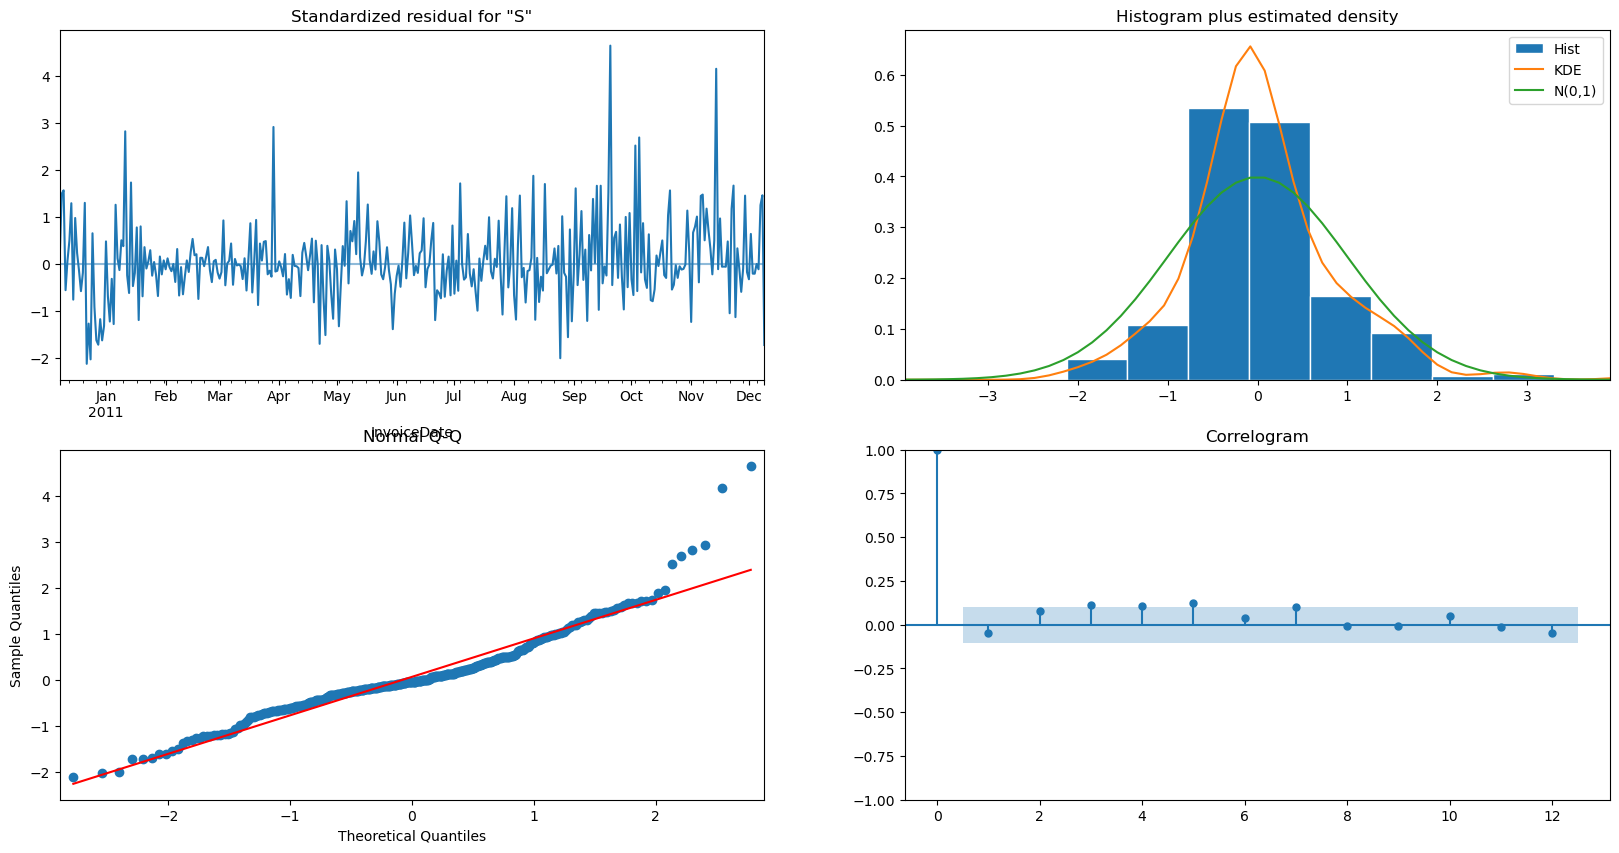

In [160]:
sar.plot_diagnostics(lags=12,figsize = (20,10),);

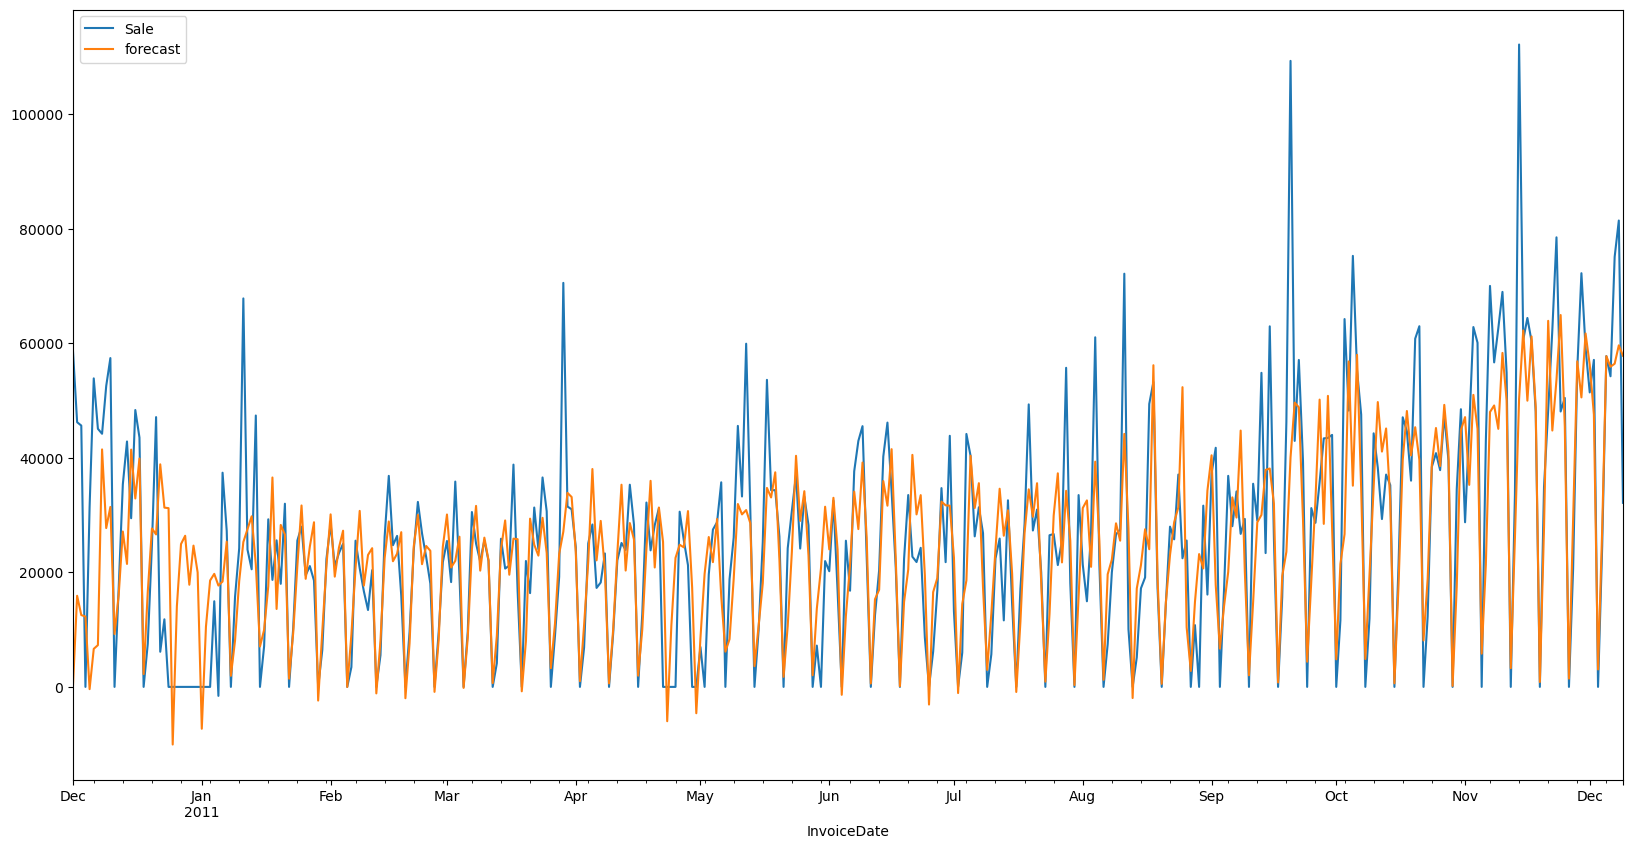

In [161]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
data_daily_sales['forecast'] = sar.predict()  
data_daily_sales[['Sale', 'forecast']].plot(figsize=(20,10));

In [167]:
def future_preds_df(model,series,num_days):
    pred_first = series.index.max()+relativedelta(days=1)
    pred_last = series.index.max()+relativedelta(days=num_days)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'D')
    vals = model.forecast(steps = num_days)
    return pd.DataFrame(vals,index = date_range_index)

In [168]:
preds = future_preds_df(sar,data_daily_sales.Sale,100)
preds

,predicted_mean
2011-12-10,-4219.919232
2011-12-11,25959.108713
2011-12-12,58235.443128
2011-12-13,55787.689890
2011-12-14,60927.794878
...,...
2012-03-14,63070.104371
2012-03-15,62687.859880
2012-03-16,48951.062119
2012-03-17,1991.082620


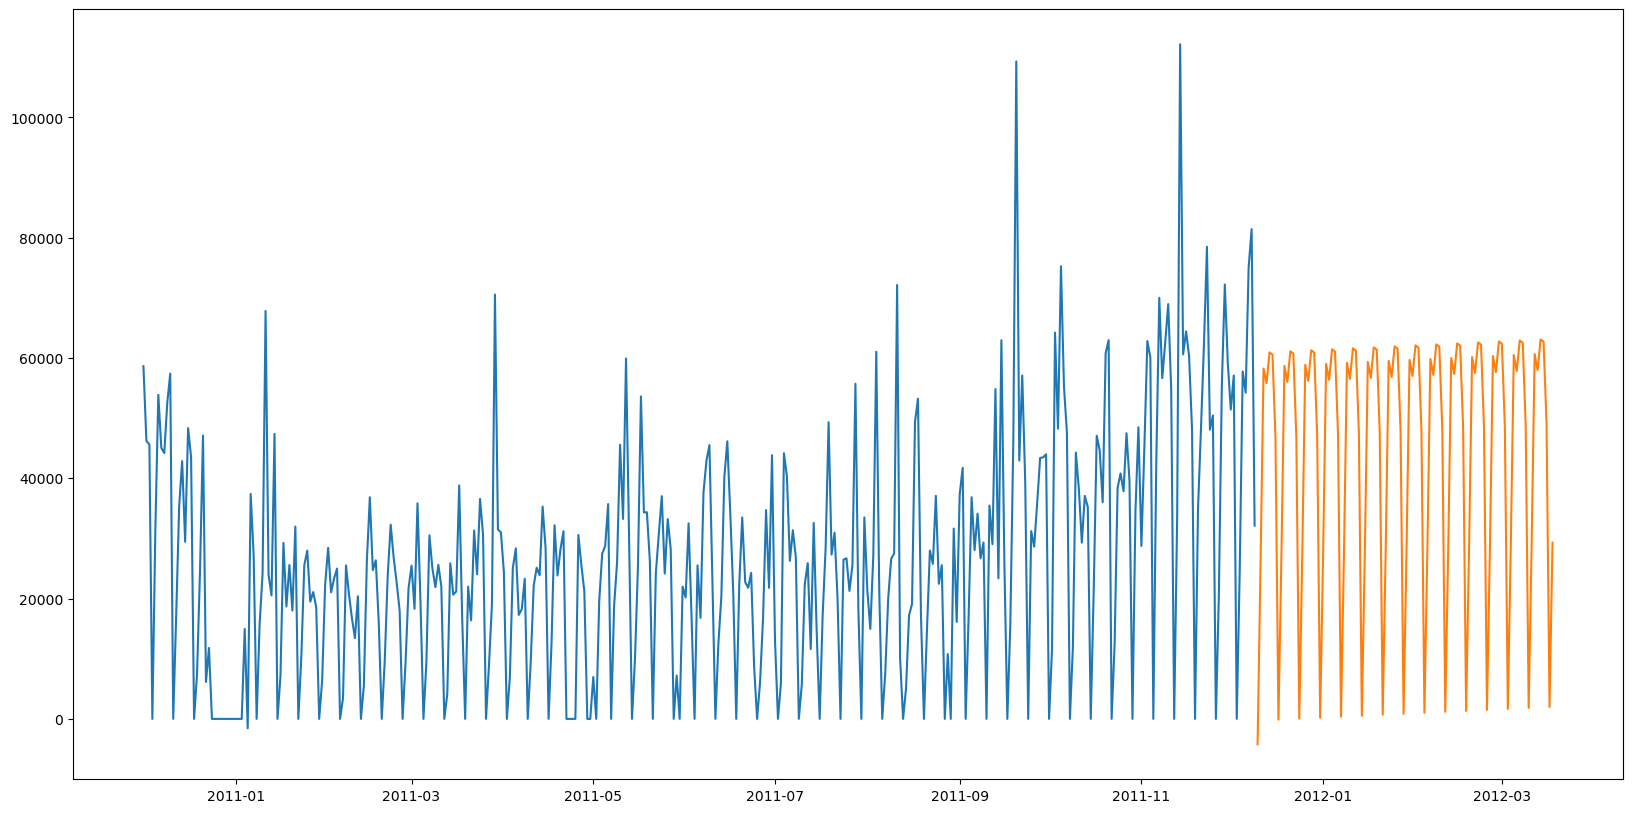

In [169]:
plt.figure(figsize=(20,10))
plt.plot(data_daily_sales.Sale)
plt.plot(preds)

## Using an auto fit

In [121]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(data_daily_sales.Sale, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=7982.156, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8115.836, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=8058.109, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=8003.588, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8113.925, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=8100.710, Time=0.11 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=7980.345, Time=0.29 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=8048.652, Time=0.15 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=7981.762, Time=0.50 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=7982.227, Time=0.58 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=7980.251, Time=0.35 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=7996.851, Time=0.17 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=7990.343, Time=0.18 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : AIC=7981.983, Time=0.74 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept

In [181]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  374
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -3984.125
Date:                                Tue, 04 Feb 2025   AIC                           7980.251
Time:                                        16:11:56   BIC                           8003.683
Sample:                                    12-01-2010   HQIC                          7989.561
                                         - 12-09-2011                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.6926     72.460      0.782      0.434     -85.327     198.713
ar.L1          0.8607      0.113      7.598      0.000       0.639       1.083
ma.L1         -0.6928      0.152     -4.557      0.000      -0.991      -0.395
ma.S.L7       -0.7252      0.076     -9.496      0.000      -0.875      -0.576
ma.S.L14      -0.1233      0.074     -1.657      0.098      -0.269       0.023
sigma2      2.213e+08   8.55e-05   2.59e+12      0.000    2.21e+08    2.21e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               379.84
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+28. Standard errors may be unstable.
"""

In [171]:
def future_preds_df(model,series,num_days):
    pred_first = series.index.max()+relativedelta(days=1)
    pred_last = series.index.max()+relativedelta(days=num_days)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'D')
    vals = model.predict(n_periods = num_days)
    return pd.DataFrame(vals,index = date_range_index)

In [172]:
preds = future_preds_df(stepwise_model,data_daily_sales.Sale,100)

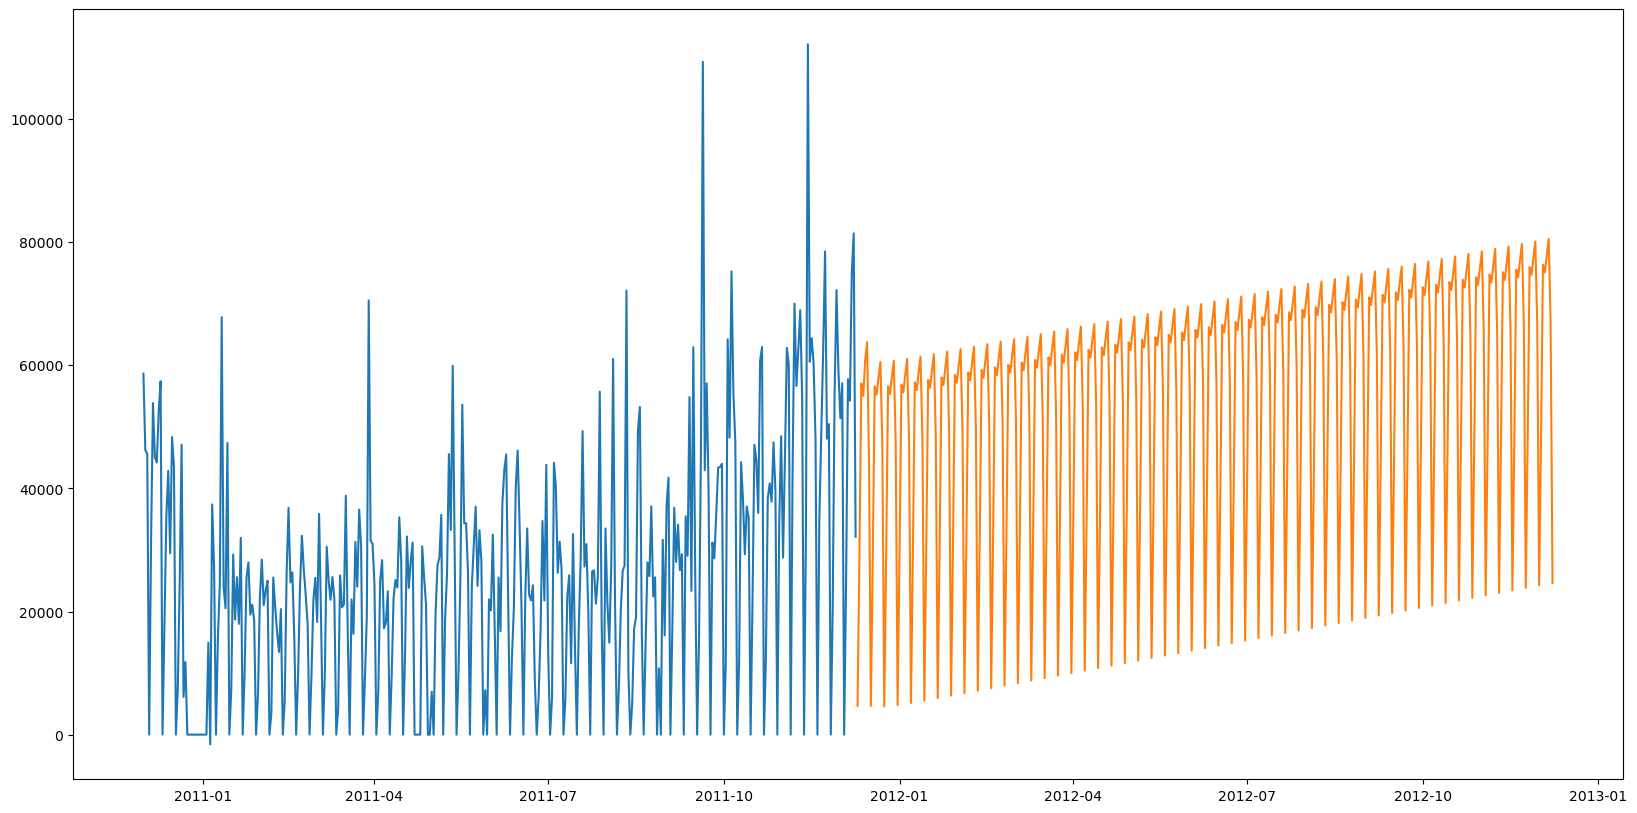

In [144]:
plt.figure(figsize=(20,10))
plt.plot(data_daily_sales.Sale)
plt.plot(preds)

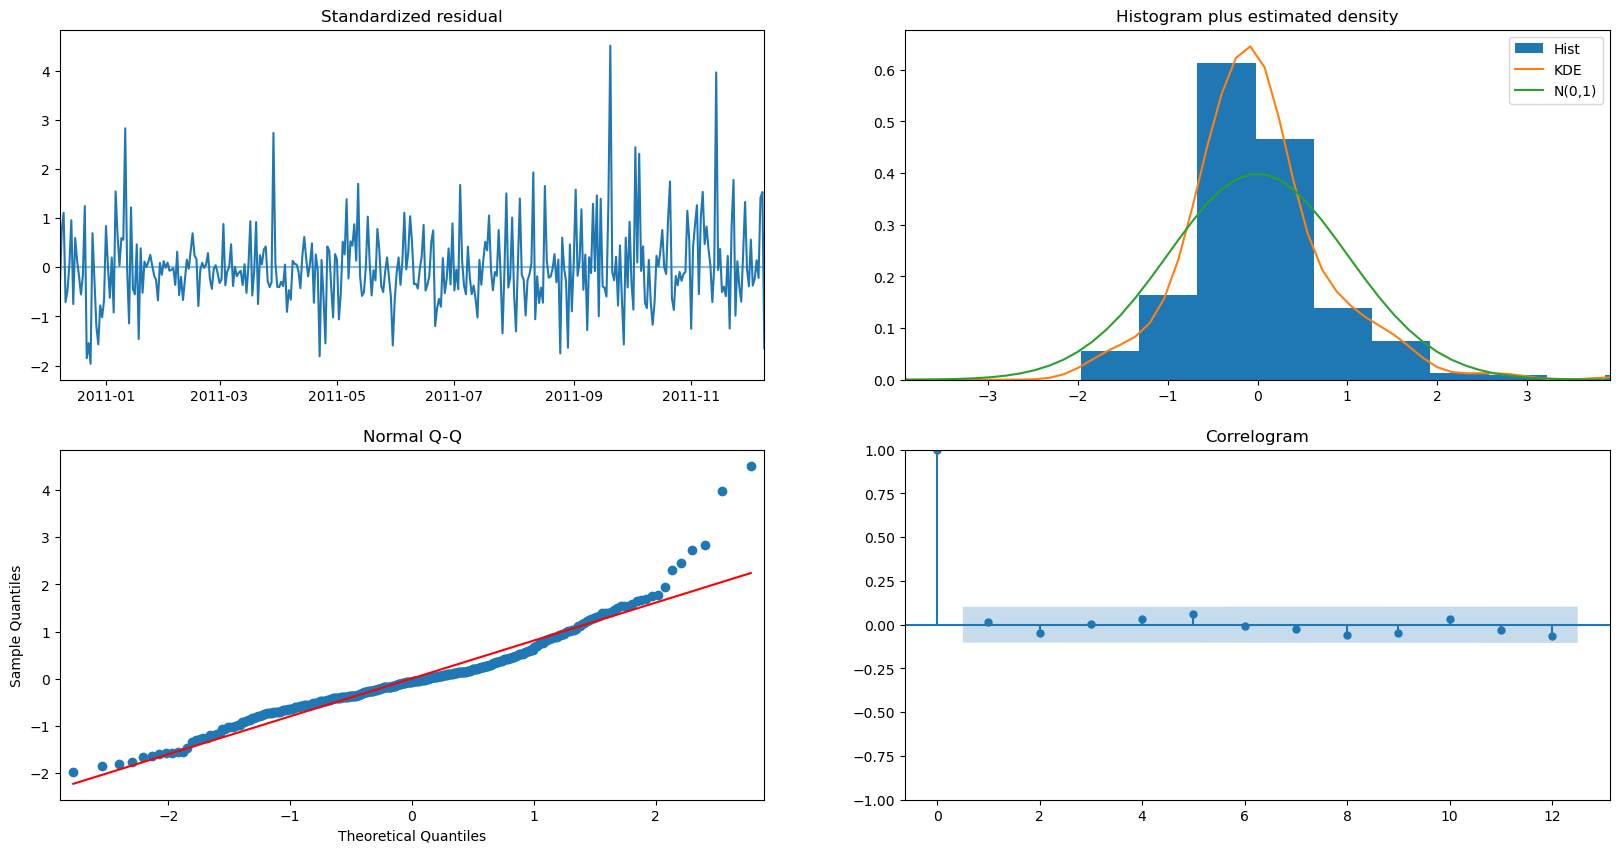

In [127]:
stepwise_model.plot_diagnostics(lags=12,figsize = (20,10),);